In [40]:
# General information
classes = ['Esophagus', 'Heart', 'Trachea', 'Aorta']
metrics = ['Dice', 'Sensitivity', 'Specificity', 'Hausdorff', 'Iou', 'Precision', 'Volumetric', 'VOE']
metrics = ['Dice', 'Hausdorff', 'Volumetric']

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

In [41]:
# model1 = "../results_metrics/samed/metrics3d/bestweights_samed_1024_r6_augment_yes_normalize_yes/test_metrics.csv"
# model2 = "../results_metrics/samed_fast/metrics3d/bestweights_samed_512_r6_augment_yes_normalize_yes/test_metrics.csv"

# label1 = "Best model resolution 1024"
# label2 = "Best model resolution 512"

In [42]:
model1 = "../results_metrics/samed_fast/metrics3d/bestweights_samed_512_r6_augment_yes_normalize_no/test_metrics.csv"
model2 = "../results_metrics/samed_fast/metrics3d/bestweights_crf_samed_512_r6_augment_yes_normalize_no/test_metrics.csv"

label1 = "Best model resolution 512"
label2 = "Best model resolution 512 + CRF"

In [43]:
data1 = pd.read_csv(model1)
data2 = pd.read_csv(model2)

In [44]:
results1 = {m: {c: [] for c in classes} for m in metrics}
results2 = {m: {c: [] for c in classes} for m in metrics}

for c in classes:
    for m in metrics:
        class_metric_data = data1[(data1['class'] == c) & (data1['metric_type'] == m)]
        mean_val = class_metric_data["metric_value"].mean()
        std_val = class_metric_data["metric_value"].std()
        
        # Append mean and std along with ablation setting
        results1[m][c].append({
            'mean': mean_val,
            'std': std_val,
            'values': class_metric_data["metric_value"]
        })

        class_metric_data = data2[(data2['class'] == c) & (data2['metric_type'] == m)]
        mean_val = class_metric_data["metric_value"].mean()
        std_val = class_metric_data["metric_value"].std()
        
        # Append mean and std along with ablation setting
        results2[m][c].append({
            'mean': mean_val,
            'std': std_val,
            'values': class_metric_data["metric_value"]
        })

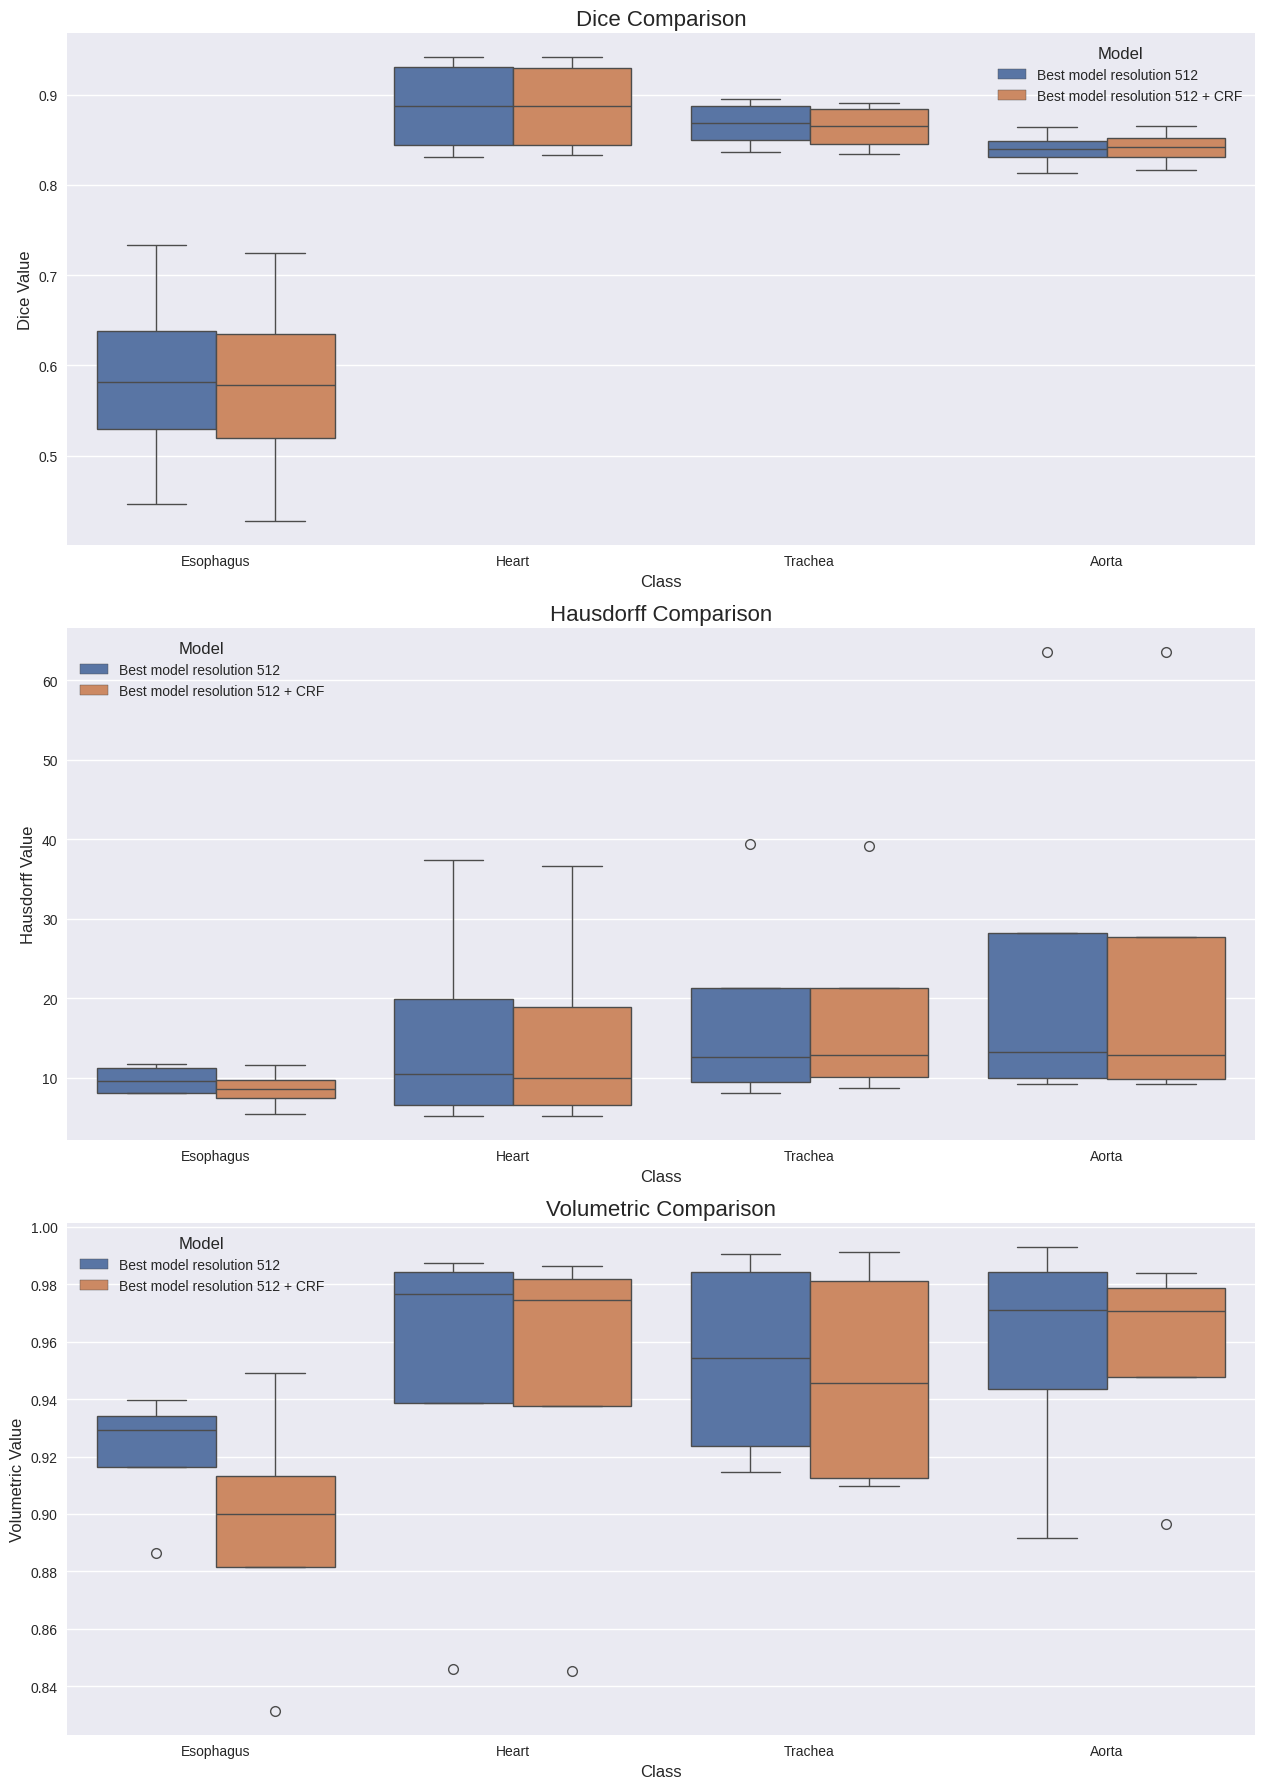

Overall Performance Metrics:
                                            Overall Mean  Overall Std
Model                           Metric                               
Best model resolution 512       Dice            0.794776     0.139676
                                Hausdorff      17.138731    15.910630
                                Volumetric      0.944525     0.044052
Best model resolution 512 + CRF Dice            0.792407     0.143676
                                Hausdorff      16.736501    15.977552
                                Volumetric      0.935914     0.051565

Best Performing Model for Each Metric and Class:
        Metric      Class                            Model  Best Score
13        Dice      Aorta        Best model resolution 512    0.863904
13        Dice      Aorta  Best model resolution 512 + CRF    0.865459
0         Dice  Esophagus        Best model resolution 512    0.733055
0         Dice  Esophagus  Best model resolution 512 + CRF    0.724618
5     

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to prepare data for plotting
def prepare_data(results):
    data = []
    for metric in metrics:
        for class_ in classes:
            for entry in results[metric][class_]:
                for value in entry['values']:  # Flattening the values
                    data.append({
                        'Metric': metric,
                        'Class': class_,
                        'Value': value,  # Individual metric value
                    })
    return pd.DataFrame(data)

# Prepare data
df1 = prepare_data(results1)
df2 = prepare_data(results2)

# Adding model information to the DataFrames
df1['Model'] = label1
df2['Model'] = label2
df_combined = pd.concat([df1, df2])

# Set up the plot style
plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(15, 6*len(metrics)))

# Box plots for each metric
for i, metric in enumerate(metrics):
    ax = axes[i] if len(metrics) > 1 else axes
    metric_data = df_combined[df_combined['Metric'] == metric]
    
    # Create boxplot
    sns.boxplot(x='Class', y='Value', hue='Model', data=metric_data, ax=ax, dodge=True)

    # Set titles and labels
    ax.set_title(f'{metric} Comparison', fontsize=16)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel(f'{metric} Value', fontsize=12)
    ax.legend(title='Model', title_fontsize=12)

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('model_comparison_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate overall performance metrics
overall_performance = df_combined.groupby(['Model', 'Metric']).agg({'Value': ['mean', 'std']})
overall_performance.columns = ['Overall Mean', 'Overall Std']
print("Overall Performance Metrics:")
print(overall_performance)

# Identify best performing model for each metric and class
best_model = df_combined.loc[df_combined.groupby(['Metric', 'Class'])['Value'].idxmax()]
best_model = best_model[['Metric', 'Class', 'Model', 'Value']].rename(columns={'Value': 'Best Score'})
print("\nBest Performing Model for Each Metric and Class:")
print(best_model)

# Calculate percentage improvement
improvement = ((df1.set_index(['Metric', 'Class'])['Value'].mean() - df2.set_index(['Metric', 'Class'])['Value'].mean()) / 
               df2.set_index(['Metric', 'Class'])['Value'].mean() * 100)
print("\nPercentage Improvement of Model 1 over Model 2:")
print(improvement)
